In [53]:
import numpy as np
import json as js
import networkx as nx
import matplotlib.pyplot as plt

In [54]:
activation = [
  'linear',
  'relu',
  'sigmoid',
  'softmax'
]

In [55]:
class Layer:
  def __init__(self, neuron_num: int, act_function: str, weights: np.array, bias: np.array):
    self.neuron_num = neuron_num
    self.weights = weights
    self.bias = bias

    case = {
        'linear': lambda x: x,
        'relu': lambda x: np.maximum(0, x),
        'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
        'softmax': lambda x: np.exp(x) / np.sum(np.exp(x))
      }
    self.act_function = case[act_function]

  def value(self, inputData: np.array):
    self.output = self.act_function(np.dot(inputData, self.weights) + self.bias)
    return self.output


In [100]:
class FFNN:
  def __init__ (self, inputData: np.array, layers: list):
    self.inputData = inputData
    self.layers = layers
    self.output = []
  
  def new_layer(self, layer: Layer):
    self.layers.append(layer)

  def forward(self):
    self.output = self.inputData
    for layer in self.layers:
      self.output = layer.value(self.output)
    return self.output
  
  def predictions(self):
    if(len(self.output.shape) == 1):
      self.output = [1 if x > 0.5 else 0 for x in self.output]
    else :
      self.output = [[1 if x > 0.5 else 0 for x in y] for y in self.output]
      



  def create_visualization(self):
    G = nx.DiGraph()

    pos = {}
    input_nodes = []
    hidden_nodes = []
    output_nodes = []
    
    if len(self.layers) == 1:
        for i in range(len(self.inputData[0])):
            for j in range(len(self.output[0])):
                weight_value = self.layers[0].weights[i][j]
                G.add_edge(f'input{i}', f'output{j}', weight=weight_value)
                pos[f'input{i}'] = np.array([0, -i])
                pos[f'output{j}'] = np.array([1, -j])
    else:
        for i in range(len(self.inputData[0])):
            node_name = f'input{i}'
            G.add_node(node_name)
            input_nodes.append(node_name)
            pos[node_name] = (0, i)

        for i in range(len(self.layers) - 1):
            layer_pos = i + 1
            for j in range(self.layers[i+1].neuron_num):
                node_name = f'hidden{i}{j}'
                G.add_node(node_name)
                hidden_nodes.append(node_name)
                pos[node_name] = (layer_pos, j)

            if i == 0:
                for j in range(len(self.inputData[0])):
                    for k in range(self.layers[i+1].neuron_num):
                        weight_value = self.layers[i].weights[j][k]
                        G.add_edge(f'input{j}', f'hidden{i}{k}', weight=weight_value)
            else:
                for j in range(self.layers[i].neuron_num):
                    for k in range(self.layers[i+1].neuron_num):
                        weight_value = self.layers[i].weights[j][k]
                        G.add_edge(f'hidden{i-1}{j}', f'hidden{i}{k}', weight=weight_value)

        for i in range(len(self.output[0])):
            node_name = f'output{i}'
            G.add_node(node_name)
            output_nodes.append(node_name)
            pos[node_name] = (len(self.layers), i)

        for i in range(self.layers[-1].neuron_num):
            for j in range(len(self.output[0])):
                weight_value = self.layers[-1].weights[i][j]
                G.add_edge(f'hidden{len(self.layers)-2}{i}', f'output{j}', weight=weight_value)

    color_map = []
    for node in G:
        if 'input' in node:
            color_map.append('lightyellow')  
        elif 'hidden' in node:
            color_map.append('lightgreen')  
        else:
            color_map.append('lightgrey')  


    plt.figure(figsize=(12, 8)) 
    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=2000, font_size=10)
    labels = nx.get_edge_attributes(G, 'weight')
    edge_alphas = [(1 if weight > 0 else 0.5) for weight in labels.values()]
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    nx.draw_networkx_edges(G, pos, edge_color='black', alpha=edge_alphas)
    plt.show()

    return G













[[0.4846748]]


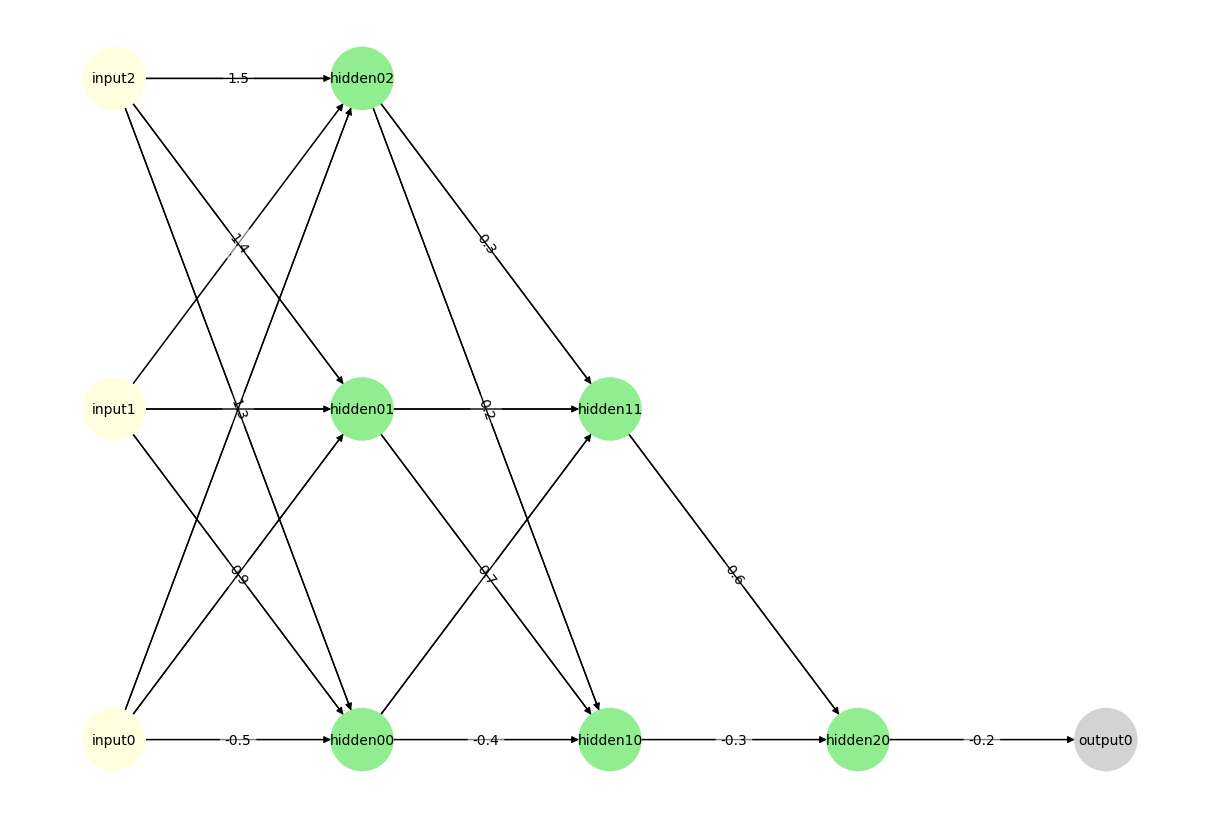

In [103]:

# read json using model
json_file = "multilayer.json"
with open (json_file, "r") as file:
    data = js.load(file)


layers = data["case"]["model"]
weights = data["case"]["weights"]
input = data["case"]["input"]


ffnn = FFNN(np.array(input), [])
for i in range (len(layers["layers"])):
  layer = layers["layers"][i]
  weight = weights[i]
  new_layer = Layer(layer["number_of_neurons"], layer["activation_function"], np.array(weight[1:]), np.array(weight[0]))
  ffnn.new_layer(new_layer)

ffnn.forward()


print(ffnn.output)
ffnn.create_visualization()



